# Parallel Wiener-Hammerstein system

See http://arxiv.org/pdf/1708.06543 for more information on the dataset.

Note that running this file multiple times with the same parameters might give different results, as the GPU parallel execution is not deterministic.


In [ ]:
import sys
sys.path.insert(0, '..')

import matplotlib.pyplot as plt
import nonlinear_benchmarks as nlb
import numpy as np
import optax 
import optimistix as optx

from src import best_linear_approximation as bla
from src import basis_functions, data_manager, full_optimization, inference_and_learning

# Load data
ParWH_full_train, ParWH_full_test = nlb.ParWH() 

# Initialise variables
N = 16384  # number of samples per period
R = 5  # number of random phase multisine realisations
P = 2  # number of periods
amplitude_level = 4  # must be one of {0, 1, 2, 3, 4}

nu, ny = 1, 1  # SISO system

fs = 78e3 # [Hz]
f_idx = np.arange(1, 4096)  # frequency lines of interest (excludes DC)

# Load data
ParWH_full_train, ParWH_full_test = nlb.ParWH() 
ParWH_train = [
    data for data in ParWH_full_train
    for phase in range(R)
    if data.name == f'Est-phase-{phase}-amp-{amplitude_level}'
]
ParWH_test = [
    data for data in ParWH_full_test
    if data.name == f'Val-amp-{amplitude_level}'
][0]

# Preprocess data
u_train = np.array([data.u for data in ParWH_train]).reshape(R, nu, N, P)
y_train = np.array([data.y for data in ParWH_train]).reshape(R, ny, N, P)
u_train = np.transpose(u_train, (2, 1, 0, 3))
y_train = np.transpose(y_train, (2, 1, 0, 3))

u_test = np.transpose(ParWH_test.u.reshape(1, nu, N, 2), (2, 1, 0, 3))
y_test = np.transpose(ParWH_test.y.reshape(1, ny, N, 2), (2, 1, 0, 3))

# Create input-output training data object
io_data = data_manager.create_data_object(u_train, y_train, f_idx, fs)

Step 1: Best Linear Approximation

In [2]:
##### (i) Nonparametric estimate #####
G_nonpar = bla.compute_nonparametric(io_data)

##### (ii) Parametrize using frequency-domain subspace identification method #####
nx = 12  # number of states
q = nx + 1  # subspace dimensioning parameter
bla_fsid = bla.freq_subspace_id(G_nonpar, nx, q)

# Simulate and check time-domain performance
u_bar = np.mean(io_data.time.u, axis=-1)  # we take the mean over the periods
y_bar = np.mean(io_data.time.y, axis=-1)  # we take the mean over the periods
handicap = 1000  # number of samples to start 'ahead of time' for transient effects to die out (only works for periodic data!)

y_sim_bla_fsid = bla_fsid.simulate(u_bar, handicap=handicap)[0]
NRMSE_bla_fsid = 100 * np.sqrt(np.mean((y_bar - y_sim_bla_fsid)**2)) / np.sqrt(np.mean(y_bar**2)) 

print(f'NRMSE of FSID BLA: {NRMSE_bla_fsid:.2f}%\n')

##### (iii) Frequency-domain iterative optimization starting from FSID BLA #####
solver = optx.LevenbergMarquardt(rtol=1e-3, atol=1e-6)
max_iter = 100

bla_opti = bla.freq_iterative_optimization(G_nonpar, bla_fsid, solver, max_iter)

# Simulate and check time-domain performance
y_sim_bla_opti = bla_opti.simulate(u_bar, handicap=handicap)[0]
NRMSE_bla_opti = 100 * np.sqrt(np.mean((y_bar - y_sim_bla_opti)**2)) / np.sqrt(np.mean(y_bar**2)) 

print(f'NRMSE of optimized BLA: {NRMSE_bla_opti:.2f}%\n')

NRMSE of FSID BLA: 13.31%

Starting iterative optimization...
   Iteration 0, Loss: 2.1803e+00
   Iteration 1, Loss: 1.7492e+00
   Iteration 2, Loss: 1.7492e+00
   Iteration 3, Loss: 1.7492e+00
   Iteration 4, Loss: 1.6736e+00
   Iteration 5, Loss: 1.6576e+00
   Iteration 6, Loss: 1.5595e+00
   Iteration 7, Loss: 1.5328e+00
   Iteration 8, Loss: 1.5101e+00
   Iteration 9, Loss: 1.4770e+00
   Iteration 10, Loss: 1.4434e+00
   Iteration 11, Loss: 1.4219e+00
   Iteration 12, Loss: 1.4133e+00
   Iteration 13, Loss: 1.4100e+00
   Iteration 14, Loss: 1.4081e+00
   Iteration 15, Loss: 1.4067e+00
   Iteration 16, Loss: 1.4054e+00
   Iteration 17, Loss: 1.4042e+00
   Iteration 18, Loss: 1.4030e+00
   Iteration 19, Loss: 1.4016e+00
   Iteration 20, Loss: 1.4001e+00
   Iteration 21, Loss: 1.3982e+00
   Iteration 22, Loss: 1.3957e+00
   Iteration 23, Loss: 1.3918e+00
   Iteration 24, Loss: 1.3918e+00
   Iteration 25, Loss: 1.3857e+00
   Iteration 26, Loss: 1.3857e+00
   Iteration 27, Loss: 1.3753e

Step 2: inference and learning

In [ ]:
# Define the nonlinear basis function
polynomial_degree = 7
nw = 2
nz = 2
phi = basis_functions.Polynomial(nz, polynomial_degree)

# Define inference and learning hyperparameters
lambda_w = 1e-1
fixed_point_iterations = 3

# As for the solver, we typically prefer a dedicated least-squares solver,
# such as the Levenberg–Marquardt (LM) algorithm. However, these solvers tend to have
# a high memory footprint, which can quickly become prohibitive for large-scale problems
# (like the one at hand). Your machine may not have enough memory to run it.
#
# This is especially true for our inference and learning approach, which involves:
# - fixed-point iterations within the loss function,
# - large feature matrices from nonlinear basis expansions,
# - multiple FFT operations and reshaping steps,
# all of which contribute to a large autodiff trace and memory pressure under LM.
#
# Fortunately, we can also opt for general-purpose minimizers that are more memory-efficient,
# such as BFGS or any first-order optimizer from the Optax library! These only require
# the gradient of a scalar loss and avoid tracing through the full residual or Jacobian.
#
# Example solver choices:
# solver = optx.LevenbergMarquardt(rtol=1e-3, atol=1e-6)
# solver = optx.OptaxMinimiser(optax.adam(learning_rate=1e-3), rtol=1e-3, atol=1e-6)
# solver = optx.BFGS(rtol=1e-3, atol=1e-6)

# Solve the problem
solver = optx.BFGS(rtol=1e-3, atol=1e-6)
nonlin_lfr = inference_and_learning.run(io_data, bla_opti, phi, nw, lambda_w, fixed_point_iterations, solver)

# Simulate and check time-domain performance
y_sim_nonlin_lfr = nonlin_lfr.simulate(u_bar, handicap=handicap)[0]
NRMSE_nonlin_lfr = 100 * np.sqrt(np.mean((y_bar - y_sim_nonlin_lfr)**2)) / np.sqrt(np.mean(y_bar**2)) 

print(f'NRMSE of NL-LFR model after inference and learning: {NRMSE_nonlin_lfr:.2f}%\n')

Starting iterative optimization...
   Iteration 0, Loss: 2.2330e+04
   Iteration 1, Loss: 2.2330e+04
   Iteration 2, Loss: 2.2330e+04
   Iteration 3, Loss: 2.2330e+04
   Iteration 4, Loss: 2.2330e+04
   Iteration 5, Loss: 2.2330e+04
   Iteration 6, Loss: 2.2330e+04
   Iteration 7, Loss: 2.2330e+04
   Iteration 8, Loss: 2.2330e+04
   Iteration 9, Loss: 2.2330e+04
   Iteration 10, Loss: 2.2330e+04
   Iteration 11, Loss: 2.2330e+04
   Iteration 12, Loss: 1.9457e+04
   Iteration 13, Loss: 1.9457e+04
   Iteration 14, Loss: 1.9457e+04
   Iteration 15, Loss: 1.9457e+04
   Iteration 16, Loss: 1.9457e+04
   Iteration 17, Loss: 1.9457e+04
   Iteration 18, Loss: 1.9457e+04
   Iteration 19, Loss: 1.9457e+04
   Iteration 20, Loss: 1.9457e+04
   Iteration 21, Loss: 1.9457e+04
   Iteration 22, Loss: 1.9457e+04
   Iteration 23, Loss: 1.4325e+04
   Iteration 24, Loss: 1.4325e+04
   Iteration 25, Loss: 1.4325e+04
   Iteration 26, Loss: 1.4325e+04
   Iteration 27, Loss: 1.4325e+04
   Iteration 28, Loss: 

Step 3: full nonlinear optimization

In [ ]:
# Regarding the solver, the same story as above applies. But this optimization step is a bit less 
# memory-hungry than inference and learning, so we can afford to use a more powerful solver.
#
# Example solver choices:
# solver = optx.LevenbergMarquardt(rtol=1e-3, atol=1e-6)
# solver = optx.OptaxMinimiser(optax.adam(learning_rate=1e-3), rtol=1e-3, atol=1e-6)
# solver = optx.BFGS(rtol=1e-3, atol=1e-6)

# Solve the problem
solver = optx.LevenbergMarquardt(rtol=1e-3, atol=1e-6)
max_iter = 100 
nonlin_lfr_opti = full_optimization.run(io_data, nonlin_lfr, solver, max_iter=max_iter)

# Simulate and check time-domain performance
y_sim_nonlin_lfr_opti = nonlin_lfr_opti.simulate(u_bar, handicap=handicap)[0]
NRMSE_nonlin_lfr_opti = 100 * np.sqrt(np.mean((y_bar - y_sim_nonlin_lfr_opti)**2)) / np.sqrt(np.mean(y_bar**2)) 

print(f'NRMSE of NL-LFR model after {max_iter} steps of full optimization: {NRMSE_nonlin_lfr_opti:.2f}%\n')

Starting iterative optimization...
   Iteration 0, Loss: 3.7027e+02
   Iteration 1, Loss: 3.7027e+02
   Iteration 2, Loss: 3.7027e+02
   Iteration 3, Loss: 3.7027e+02
   Iteration 4, Loss: 3.7027e+02
   Iteration 5, Loss: 3.7027e+02
   Iteration 6, Loss: 3.7027e+02
   Iteration 7, Loss: 3.7027e+02
   Iteration 8, Loss: 3.7027e+02
   Iteration 9, Loss: 3.7027e+02
   Iteration 10, Loss: 2.9730e+02
   Iteration 11, Loss: 2.7650e+02
   Iteration 12, Loss: 2.6400e+02
   Iteration 13, Loss: 2.4564e+02
   Iteration 14, Loss: 2.2465e+02
   Iteration 15, Loss: 2.0243e+02
   Iteration 16, Loss: 1.7279e+02
   Iteration 17, Loss: 1.5454e+02
   Iteration 18, Loss: 1.5454e+02
   Iteration 19, Loss: 1.4265e+02
   Iteration 20, Loss: 1.3356e+02
   Iteration 21, Loss: 1.2630e+02
   Iteration 22, Loss: 1.2002e+02
   Iteration 23, Loss: 1.1453e+02
   Iteration 24, Loss: 1.0959e+02
   Iteration 25, Loss: 1.0507e+02
   Iteration 26, Loss: 1.0096e+02
   Iteration 27, Loss: 9.7270e+01
   Iteration 28, Loss: 

Evaluate the model on test data

NRMSE of BLA model on test data: 11.29%
NRMSE of NL-LFR model on test data: 0.56%



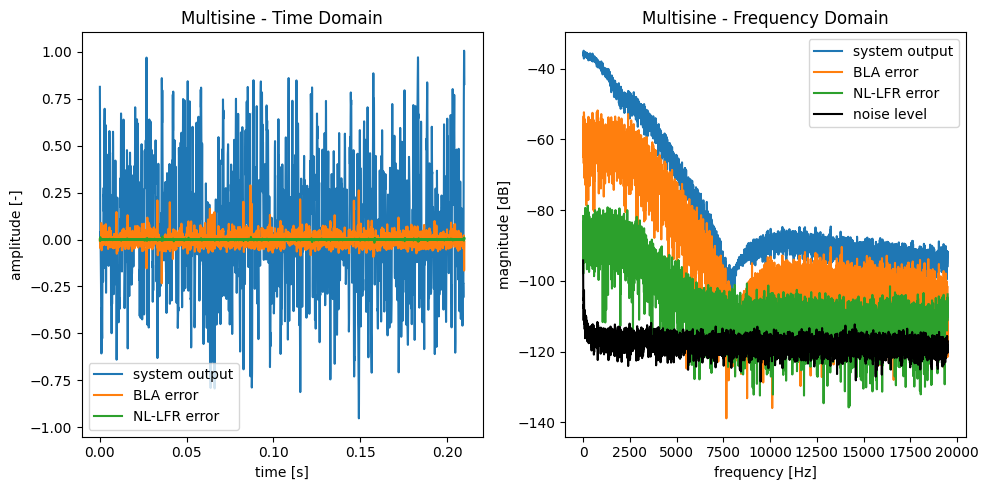

In [5]:
# Multisine test
u_test = np.transpose(ParWH_test.u.reshape(1, nu, N, 2), (2, 1, 0, 3))
y_test = ParWH_test.y[::2]
u_test = (u_test - io_data.norm.u_mean) / io_data.norm.u_std

y_test_bla_normalized = bla_opti.simulate(u_test[:, :, :, 0], handicap=handicap)[0][:, 0, 0]
y_test_bla = y_test_bla_normalized * io_data.norm.y_std + io_data.norm.y_mean
NRMSE_test_bla = 100 * np.sqrt(np.mean((y_test - y_test_bla)**2)) / np.sqrt(np.mean(y_test**2))
print(f'NRMSE of BLA model on test data: {NRMSE_test_bla:.2f}%')

y_test_nonlin_lfr_normalized = nonlin_lfr_opti.simulate(u_test[:, :, :, 0], handicap=handicap)[0][:, 0, 0]
y_test_nonlin_lfr = y_test_nonlin_lfr_normalized * io_data.norm.y_std + io_data.norm.y_mean
NRMSE_test_nonlin_lfr = 100 * np.sqrt(np.mean((y_test - y_test_nonlin_lfr)**2)) / np.sqrt(np.mean(y_test**2)) 
print(f'NRMSE of NL-LFR model on test data: {NRMSE_test_nonlin_lfr:.2f}%\n')

Y_test = 1 / N * np.fft.rfft(y_test, axis=0)
Y_test_bla = 1 / N * np.fft.rfft(y_test_bla, axis=0)
Y_test_nonlin_lfr = 1 / N * np.fft.rfft(y_test_nonlin_lfr, axis=0)

# Compute noise level
Y = io_data.norm.y_mean + 1 / N * (io_data.norm.y_std * io_data.freq.Y)
Y_P = Y.mean(axis=3)  # we take the average over periods
if P > 1:
    var_noise = ((np.abs(Y - Y_P[..., None])**2).sum(axis=(2, 3))
                  / R / (P - 1))
else:
    var_noise = None

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(io_data.time.t, y_test, label='system output')
axs[0].plot(io_data.time.t, y_test - y_test_bla, label='BLA error')
axs[0].plot(io_data.time.t, y_test - y_test_nonlin_lfr, label='NL-LFR error')
axs[0].set_title('Multisine - Time Domain')
axs[0].set_xlabel('time [s]')
axs[0].set_ylabel('amplitude [-]')
axs[0].legend()

axs[1].plot(io_data.freq.f[f_idx], 20*np.log10(np.abs(Y_test[f_idx])), label='system output')
axs[1].plot(io_data.freq.f[f_idx], 20*np.log10(np.abs(Y_test[f_idx] - Y_test_bla[f_idx])), label='BLA error')
axs[1].plot(io_data.freq.f[f_idx], 20*np.log10(np.abs(Y_test[f_idx] - Y_test_nonlin_lfr[f_idx])), label='NL-LFR error')
if var_noise is not None:
    axs[1].plot(io_data.freq.f[f_idx], 20*np.log10(np.sqrt(var_noise[f_idx])), 'k', label='noise level')
axs[1].set_title('Multisine - Frequency Domain')
axs[1].set_xlabel('frequency [Hz]')
axs[1].set_ylabel('magnitude [dB]')
axs[1].legend()
plt.tight_layout()
plt.show()